#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.ensemble import StackingClassifier


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [5]:
#전체 데이터 불러오기
# file = r'../data/data01_train.csv'
file = r'/content/drive/MyDrive/AI+X_중급/data/data01_train.csv'

raw_data = pd.read_csv(file)
raw_data.drop('subject',axis=1,inplace=True) #비식별화 (개별 피험자에게 관심 있는 것이 아님)
data = raw_data.copy()
raw_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [6]:
#전체 데이터 불러오기
# file = r'../data/data01_test.csv'
file = r'/content/drive/MyDrive/AI+X_중급/data/data01_test.csv'

new_data = pd.read_csv(file)
new_data.drop('subject',axis=1,inplace=True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [7]:
# 'Activity' 열을 정적(0)/동적(1)으로 매핑

activity_mapping = {'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1,
                    'LAYING': 0, 'STANDING': 0, 'SITTING': 0}

In [8]:
data['Activity'] = data['Activity'].map(activity_mapping)

# y1 : Activity, y2 : Activity_dynamic
y1 = data['Activity']
y2 = data['Activity']

# X : feature columns
X = data.drop(['Activity'], axis=1)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y2, test_size=0.2, random_state=42)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : XGBOOST

In [11]:
# ------------------- 전체 변수로 모델링 -------------------

# XGBoost 모델 학습 - 전체 변수 사용
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"XGBoost 모델의 정확도 (전체 변수): {accuracy:.4f}")

XGBoost 모델의 정확도 (전체 변수): 1.0000


- GridSearchCV

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

최적의 하이퍼파라미터: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 1.0000


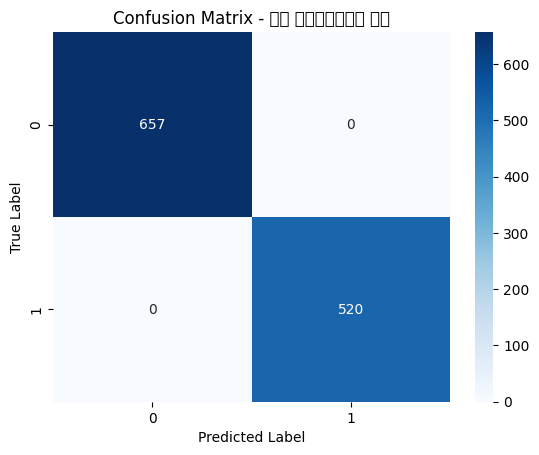

In [12]:
# XGBoost 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

# 최적의 모델로 예측 및 성능 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

# Confusion Matrix 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - 최적 하이퍼파라미터 적용')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- Hyperopt

In [13]:
# ------------------- Hyperopt로 하이퍼파라미터 튜닝 -------------------

# 검색 공간 정의
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

In [14]:
# 목적 함수 정의
def XGB_objective(params):
    xgb_model = XGBClassifier(**params, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Hyperopt는 최소화 문제로 다루기 때문에 음수 정확도를 반환
    return {'loss': -accuracy, 'status': STATUS_OK}

In [15]:
# Hyperopt 실행
trials = Trials()
best_params = fmin(fn=XGB_objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials,
                   rstate=np.random.default_rng(42))

print(f"최적의 하이퍼파라미터: {best_params}")

# 최적 하이퍼파라미터로 모델 학습 및 평가
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

100%|██████████| 30/30 [00:57<00:00,  1.93s/trial, best loss: -1.0]
최적의 하이퍼파라미터: {'colsample_bytree': 0.9071425591061504, 'learning_rate': 0.07045898968498444, 'max_depth': 14.0, 'n_estimators': 350.0, 'subsample': 0.9254621630561151}
XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 1.0000


#### 2) 알고리즘2 : LightGBM

In [16]:
# ------------------- 전체 변수로 모델링 -------------------

# LightGBM 모델 학습 - 전체 변수 사용
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred = lgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"LightGBM 모델의 정확도 (전체 변수): {accuracy:.4f}")

[LightGBM] [Info] Number of positive: 2127, number of negative: 2577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140145
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452168 -> initscore=-0.191913
[LightGBM] [Info] Start training from score -0.191913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

- hyperOpt

In [18]:
# 목적 함수 정의
def LGB_objective(params):
    lgb_model = lgb.LGBMClassifier(**params, random_state=42)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Hyperopt는 최소화 문제로 다루기 때문에 음수 정확도를 반환
    return {'loss': -accuracy, 'status': STATUS_OK}

In [19]:
# 하이퍼파라미터 공간 정의
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.1, 0.2]),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.6, 0.8, 1.0])
}

# Hyperopt 실행
trials = Trials()
best_params = fmin(fn=LGB_objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials,
                   rstate=np.random.default_rng(42))

print(f"최적의 하이퍼파라미터: {best_params}")

# 최적 하이퍼파라미터로 모델 학습 및 평가
best_params['n_estimators'] = [50, 100, 200][best_params['n_estimators']]
best_params['max_depth'] = [3, 5, 7][best_params['max_depth']]
best_params['learning_rate'] = [0.01, 0.1, 0.2][best_params['learning_rate']]
best_params['subsample'] = [0.6, 0.8, 1.0][best_params['subsample']]
best_params['colsample_bytree'] = [0.6, 0.8, 1.0][best_params['colsample_bytree']]

best_model = lgb.LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"LightGBM 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

[LightGBM] [Info] Number of positive: 2127, number of negative: 2577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140145
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452168 -> initscore=-0.191913
[LightGBM] [Info] Start training from score -0.191913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

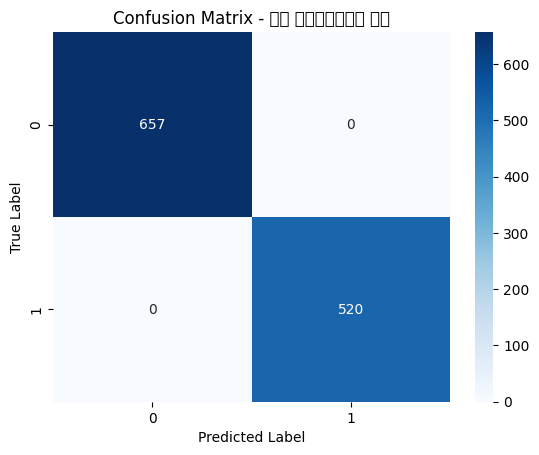

In [20]:
# Confusion Matrix 시각화
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - 최적 하이퍼파라미터 적용')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### 3) 알고리즘3 : CatBoost

In [21]:
# 동적/정적 예측 모델 (Step 1)
step1_model = CatBoostClassifier(random_state=42, verbose=0)
step1_model.fit(X_train, y_train)  # y2_train은 동적/정적 예측 레이블

# Step 1 모델을 사용하여 동적/정적 예측
y_pred = step1_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (전체 변수): {accuracy:.4f}")

CatBoost 모델의 정확도 (전체 변수): 1.0000


In [22]:
# 목적 함수 정의
def CatBoost_objective(params):
    catboost_model = CatBoostClassifier(**params, random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    y_pred = catboost_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Hyperopt는 최소화 문제로 다루기 때문에 음수 정확도를 반환
    return {'loss': -accuracy, 'status': STATUS_OK}

In [23]:
# 하이퍼파라미터 탐색 공간 정의
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),  # 100에서 1000 사이에서 50 단위로 탐색
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # 0.01에서 0.3 사이 실수형 탐색
    'depth': hp.quniform('depth', 4, 10, 1),  # 깊이는 4부터 10까지 1씩 증가
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),  # L2 regularization 값
    'border_count': hp.quniform('border_count', 32, 255, 1)  # 학습 시 사용하는 분할 경계 수
}

In [ ]:
# Hyperopt 실행
trials = Trials()
best_params = fmin(fn=CatBoost_objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials,
                   rstate=np.random.default_rng(42))

print(f"최적의 하이퍼파라미터: {best_params}")

# 최적 하이퍼파라미터로 모델 학습 및 평가
best_params['iterations'] = int(best_params['iterations'])
best_params['depth'] = int(best_params['depth'])

step1_best_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
step1_best_model.fit(X_train, y_train)
y_pred = step1_best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

In [26]:
#hyperOpt로 하이퍼파라미터 튜닝한 모델 돌리기
step1_best_model = CatBoostClassifier(border_count= 203.0, depth= 8.0, iterations= 900.0, l2_leaf_reg= 6.58107097908977, learning_rate= 0.24596006821568345, random_state=42, task_type='GPU', devices='0', verbose=0)
step1_best_model.fit(X_train, y_train)
y_pred = step1_best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 1.0000


### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [61]:
data = raw_data.copy()

In [62]:
# 정적 행동(Laying, Sitting, Standing)만 추출
static_activities = ['LAYING', 'SITTING', 'STANDING']
data_static = data[data['Activity'].isin(static_activities)]

# y1 : Activity (정적 행동에 대한 레이블)
y1 = data_static['Activity']

# Label Encoding for y1
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y1)

# X : feature columns (특징 값)
X = data_static.drop(['Activity'], axis=1)

In [63]:
# # 클래스와 인코딩된 값의 매핑을 딕셔너리로 출력
# class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print(class_mapping)

In [64]:
X_scaled = scaler.transform(X)

In [65]:
# 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y1_encoded, test_size=0.2, random_state=42)

In [32]:
# 모델 리스트
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, task_type='GPU', devices='0', random_state=42)
}


# 모델 학습 및 평가
best_accuracy = 0
best_model_name = ""
best_model = None

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    print(f"{model_name} 모델의 정확도: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = model

# 최적 모델 출력
print(f"가장 성능이 좋은 모델은 {best_model_name}이며, 정확도는 {best_accuracy:.4f}입니다.")

RandomForest 모델의 정확도: 0.9691
LogisticRegression 모델의 정확도: 0.9660
SVM 모델의 정확도: 0.9598
XGBoost 모델의 정확도: 0.9815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139351
[LightGBM] [Info] Number of data points in the train set: 2587, number of used features: 561
[LightGBM] [Info] Start training from score -1.062548
[LightGBM] [Info] Start training from score -1.140449
[LightGBM] [Info] Start training from score -1.094369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [33]:
# 검색 공간 정의
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

#### catBoost

In [34]:
#hyperOpt로 하이퍼파라미터 튜닝한 모델 돌리기
step2_1_best_model = CatBoostClassifier(border_count= 65.0, depth= 10.0, iterations= 400.0, l2_leaf_reg= 1.9277385952290542, learning_rate= 0.1042352190953018, random_state=42, task_type='GPU', devices='0', verbose=0)
step2_1_best_model.fit(X_train, y_train)
y_pred = step2_1_best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 0.9923


In [36]:
# # Hyperopt 실행
# trials = Trials()
# best_params = fmin(fn=CatBoost_objective,
#                    space=space,
#                    algo=tpe.suggest,
#                    max_evals=30,
#                    trials=trials,
#                    rstate=np.random.default_rng(42))

# print(f"최적의 하이퍼파라미터: {best_params}")

# # 최적 하이퍼파라미터로 모델 학습 및 평가
# best_params['iterations'] = int(best_params['iterations'])
# best_params['depth'] = int(best_params['depth'])

# step2_1_best_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
# step2_1_best_model.fit(X_train, y_train)
# y_pred = step2_1_best_model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)

# # 정확도 출력
# print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

#### LightGBM - HyperOpt로 파라미터 튜닝함



In [35]:
# ------------------- 전체 변수로 모델링 -------------------

# LightGBM 모델 학습 - 전체 변수 사용
lgb_model = lgb.LGBMClassifier(colsample_bytree= 0.6, learning_rate= 0.2, max_depth= 5, n_estimators= 200, subsample= 0.6,random_state=42)
lgb_model.fit(X_train, y_train)

# 예측 및 성능 평가 - 전체 변수 사용
y_pred = lgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"LightGBM 모델의 정확도 (전체 변수): {accuracy:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139351
[LightGBM] [Info] Number of data points in the train set: 2587, number of used features: 561
[LightGBM] [Info] Start training from score -1.062548
[LightGBM] [Info] Start training from score -1.140449
[LightGBM] [Info] Start training from score -1.094369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

#### xgboost hyperopt

In [56]:
# 목적 함수 정의
def XGBoost_objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['max_bin'] = int(params['max_bin'])

    xgb_model = XGBClassifier(**params, random_state=42, tree_method='hist', device='cuda')  # GPU 사용 설정
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Hyperopt는 최소화 문제로 다루기 때문에 음수 정확도를 반환
    return {'loss': -accuracy, 'status': STATUS_OK}

# 하이퍼파라미터 탐색 공간 정의 (Hyperopt가 제공하는 방법으로 변경)
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_child_weight': hp.uniform('min_child_weight', 0.01, 10.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 5.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 32, 256, 1)
}

# Hyperopt 실행
trials = Trials()
best_params = fmin(fn=XGBoost_objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials,
                   rstate=np.random.default_rng(42))

print(f"최적의 하이퍼파라미터: {best_params}")

# 최적 하이퍼파라미터로 모델 학습 및 평가
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['max_bin'] = int(best_params['max_bin'])

xgb_model = XGBClassifier(**best_params, random_state=42, tree_method='hist', device='cuda')  # GPU 사용 설정
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

100%|██████████| 30/30 [00:28<00:00,  1.04trial/s, best loss: -0.990726429675425]
최적의 하이퍼파라미터: {'colsample_bytree': 0.7299325324725982, 'gamma': 0.12044732616774778, 'learning_rate': 0.06482021876983714, 'max_bin': 33.0, 'max_depth': 3.0, 'min_child_weight': 6.817387945231493, 'n_estimators': 299.0, 'reg_alpha': 0.7517332478114824, 'reg_lambda': 0.32499254775660713, 'subsample': 0.9997677088550361}
XGBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 0.9907
Confusion Matrix:
[[221   0   0]
 [  0 203   2]
 [  0   4 217]]


#### 정적 동작 세부 분류 -> 스택킹 앙상블 수행
- 분류 모델 중 정적 모델 분류 성능이 제일 좋지않아 추가로 stacking 앙상블 수행





In [66]:
def train_meta_model_with_trained_base_models(X_train_static, y_train_static, static_models, meta_model):
    """
    정적 행동 분류에 대한 스택킹 메타 모델 학습.
    이미 학습된 모델들을 사용하고, 메타 모델만 학습.
    """
    # 학습된 모델들을 사용한 스택킹 앙상블 구성
    estimators = [(f'model_{i}', model) for i, model in enumerate(static_models)]

    # StackingClassifier에서 메타 모델만 학습, 기존 모델들은 학습되지 않음
    static_model_ensemble = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5, passthrough=True)

    # 메타 모델만 학습
    static_model_ensemble.fit(X_train_static, y_train_static)

    return static_model_ensemble

In [67]:
static_models = [step2_1_best_model, xgb_model, lgb_model]  # 정적 행동을 위한 3개의 모델

meta = LogisticRegression()
static_model_ensemble = train_meta_model_with_trained_base_models(X_train,y_train,static_models,meta)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139351
[LightGBM] [Info] Number of data points in the train set: 2587, number of used features: 561
[LightGBM] [Info] Start training from score -1.062548
[LightGBM] [Info] Start training from score -1.140449
[LightGBM] [Info] Start training from score -1.094369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [38]:
data = raw_data.copy()

In [39]:
# 정적 행동(Laying, Sitting, Standing)만 추출
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data_static = data[data['Activity'].isin(dynamic_activities)]

# y1 : Activity (정적 행동에 대한 레이블)
y1 = data_static['Activity']

# Label Encoding for y1
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y1)

# X : feature columns (특징 값)
X = data_static.drop(['Activity'], axis=1)

In [40]:
X_scaled = scaler.transform(X)

In [41]:
# 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y1_encoded, test_size=0.2, random_state=42)

In [42]:
# 모델 리스트
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, task_type='GPU', devices='0')
}


# 모델 학습 및 평가
best_accuracy = 0
best_model_name = ""
best_model = None

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    print(f"{model_name} 모델의 정확도: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = model

# 최적 모델 출력
print(f"가장 성능이 좋은 모델은 {best_model_name}이며, 정확도는 {best_accuracy:.4f}입니다.")

RandomForest 모델의 정확도: 0.9887
LogisticRegression 모델의 정확도: 0.9962
SVM 모델의 정확도: 0.9962
XGBoost 모델의 정확도: 0.9925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139790
[LightGBM] [Info] Number of data points in the train set: 2117, number of used features: 561
[LightGBM] [Info] Start training from score -0.970647
[LightGBM] [Info] Start training from score -1.215215
[LightGBM] [Info] Start training from score -1.125421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# 목적 함수 정의
def CatBoost_objective(params):
    catboost_model = CatBoostClassifier(**params, random_state=42, task_type='GPU', devices='0', verbose=0)
    catboost_model.fit(X_train, y_train)
    y_pred = catboost_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Hyperopt는 최소화 문제로 다루기 때문에 음수 정확도를 반환
    return {'loss': -accuracy, 'status': STATUS_OK}

# Hyperopt 실행
trials = Trials()
best_params = fmin(fn=CatBoost_objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials,
                   rstate=np.random.default_rng(42))

print(f"최적의 하이퍼파라미터: {best_params}")

# 최적 하이퍼파라미터로 모델 학습 및 평가
best_params['iterations'] = int(best_params['iterations'])
best_params['depth'] = int(best_params['depth'])
best_params['border_count'] = int(best_params['border_count'])

step2_2_best_model = CatBoostClassifier(**best_params, random_state=42, task_type='GPU', devices='0', verbose=0)
step2_2_best_model.fit(X_train, y_train)
y_pred = step2_2_best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")


In [ ]:
# # Hyperopt 실행
# trials = Trials()
# best_params = fmin(fn=CatBoost_objective,
#                    space=space,
#                    algo=tpe.suggest,
#                    max_evals=30,
#                    trials=trials,
#                    rstate=np.random.default_rng(42))

# print(f"최적의 하이퍼파라미터: {best_params}")

# # 최적 하이퍼파라미터로 모델 학습 및 평가
# best_params['iterations'] = int(best_params['iterations'])
# best_params['depth'] = int(best_params['depth'])

# step2_2_best_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
# step2_2_best_model.fit(X_train, y_train)
# y_pred = step2_2_best_model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)

# # 정확도 출력
# print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

In [43]:
#hyperOpt로 하이퍼파라미터 튜닝한 모델 돌리기
step2_2_best_model = CatBoostClassifier(border_count= 48.0, depth= 8.0, iterations= 650.0, l2_leaf_reg= 2.909954052940017, learning_rate= 0.12709552437597396, random_state=42, task_type='GPU', devices='0', verbose=0)
step2_2_best_model.fit(X_train, y_train)
y_pred = step2_2_best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# 정확도 출력
print(f"CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): {accuracy:.4f}")

CatBoost 모델의 정확도 (최적 하이퍼파라미터 적용): 1.0000


In [ ]:
# 예측 및 성능 평가 - F1 Score 계산
y_pred = step2_2_best_model.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')  # 'weighted'는 클래스 불균형을 고려한 평균

# F1 Score 출력
print(f"CatBoost 모델의 F1 Score (최적 하이퍼파라미터 적용): {f1:.4f}")



### (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [46]:
#stacking 앙상블 없는 코드
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pandas as pd

def predict_and_evaluate_pipeline(new_data, step1_model, dynamic_model, static_model, sc):
    """
    입력: 원본 test 데이터셋 (new_data), 학습된 모델들
    출력: 예측 결과 및 성능 평가 결과
    """
    # 입력 데이터와 라벨 분리
    X_test = new_data.drop('Activity', axis=1)
    y_test = new_data['Activity']

    # 전처리 (스케일링)
    X_test_scaled = sc.transform(X_test)  # 스케일링 적용

    # Step 1: 라벨 인코딩
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)  # y_test 라벨 인코딩

    # 클래스와 인코딩된 값의 매핑을 딕셔너리로 출력
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"Class Mapping: {class_mapping}")

    # Step 2: 동적/정적 예측 모델 (Step 1) 수행
    dynamic_static_pred = step1_model.predict(X_test_scaled)

    # 'Activity' 열을 정적(0)/동적(1)으로 매핑
    activity_mapping = {'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1, 'LAYING': 0, 'STANDING': 0, 'SITTING': 0}
    dynamic_static_pred_ans = y_test.map(activity_mapping)

    # 동적/정적 예측 모델의 정확도 계산
    step1_accuracy = accuracy_score(dynamic_static_pred_ans, dynamic_static_pred)
    print(f"Step1 (동적/정적 예측 모델) 정확도: {step1_accuracy:.4f}")

    # 동적 및 정적 행동 분리
    X_test_dynamic = X_test_scaled[dynamic_static_pred == 1]  # 동적 행동 데이터
    X_test_static = X_test_scaled[dynamic_static_pred == 0]   # 정적 행동 데이터
    y_test_dynamic = y_test[dynamic_static_pred == 1]         # 동적 행동 라벨
    y_test_static = y_test[dynamic_static_pred == 0]          # 정적 행동 라벨

    # 최종 예측 결과 저장할 리스트
    final_preds = []

    dynamic_preds = []
    static_preds = []

    # Step 3: 각 샘플에 대해 예측 수행
    for i in range(len(X_test_scaled)):
        if dynamic_static_pred[i] == 1:  # 동적 행동인 경우
            dynamic_pred = dynamic_model.predict([X_test_scaled[i]]).ravel()  # 동적 행동 예측
            if dynamic_pred.size > 0:
                pred = label_encoder.inverse_transform([dynamic_pred[0] + 3])[0]  # 라벨 변환 (3을 더한 값)
                dynamic_preds.append(pred)
                final_preds.append(pred)
        else:  # 정적 행동인 경우
            static_pred = static_model.predict([X_test_scaled[i]]).ravel()  # 정적 행동 예측
            if static_pred.size > 0:
                pred = label_encoder.inverse_transform([static_pred[0]])[0]  # 라벨 변환
                static_preds.append(pred)
                final_preds.append(pred)

    # Step 4: 성능 평가
    overall_accuracy = accuracy_score(y_test, final_preds)
    overall_f1 = f1_score(y_test, final_preds, average='weighted')
    conf_matrix = confusion_matrix(y_test, final_preds)

    # 동적 행동 정확도 계산
    if len(dynamic_preds) > 0:
        dynamic_accuracy = accuracy_score(y_test_dynamic, dynamic_preds)
        print(f"동적 행동 정확도: {dynamic_accuracy:.4f}")
    else:
        dynamic_accuracy = None
        print("동적 행동 데이터가 없습니다.")

    # 정적 행동 정확도 계산
    if len(static_preds) > 0:
        static_accuracy = accuracy_score(y_test_static, static_preds)
        print(f"정적 행동 정확도: {static_accuracy:.4f}")
    else:
        static_accuracy = None
        print("정적 행동 데이터가 없습니다.")

    # 전체 성능 출력
    print(f"최종 모델 정확도: {overall_accuracy:.4f}")
    print(f"최종 모델 F1 스코어: {overall_f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'step1_accuracy': step1_accuracy,
        'dynamic_accuracy': dynamic_accuracy,
        'static_accuracy': static_accuracy,
        'overall_accuracy': overall_accuracy,
        'overall_f1': overall_f1,
        'confusion_matrix': conf_matrix
    }

In [47]:
results = predict_and_evaluate_pipeline(new_data, step1_model, step2_2_best_model, step2_1_best_model, scaler)

Class Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
Step1 (동적/정적 예측 모델) 정확도: 1.0000
동적 행동 정확도: 0.9984
정적 행동 정확도: 0.9820
최종 모델 정확도: 0.9891
최종 모델 F1 스코어: 0.9891
Confusion Matrix:
[[292   0   0   0   0   0]
 [  0 247   7   0   0   0]
 [  0   8 279   0   0   0]
 [  0   0   0 227   0   1]
 [  0   0   0   0 195   0]
 [  0   0   0   0   0 215]]


### 정확도 : 0.9891

## Stacking Ensemble 수행

In [68]:
def predict_and_evaluate_pipeline(new_data, step1_model, dynamic_model, static_model_ensemble, sc):
    """
    입력: 원본 test 데이터셋 (new_data), 학습된 모델들 (step1_model, dynamic_model, static_model_ensemble)
    출력: 예측 결과 및 성능 평가 결과
    """
    # 입력 데이터와 라벨 분리
    X_test = new_data.drop('Activity', axis=1)
    y_test = new_data['Activity']

    # 전처리 (스케일링)
    X_test_scaled = sc.transform(X_test)  # 스케일링 적용

    # Step 1: 라벨 인코딩
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)  # y_test 라벨 인코딩

    # 클래스와 인코딩된 값의 매핑을 딕셔너리로 출력
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"Class Mapping: {class_mapping}")

    # Step 2: 동적/정적 예측 모델 (Step 1) 수행
    dynamic_static_pred = step1_model.predict(X_test_scaled)

    # 'Activity' 열을 정적(0)/동적(1)으로 매핑
    activity_mapping = {'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1, 'LAYING': 0, 'STANDING': 0, 'SITTING': 0}
    dynamic_static_pred_ans = y_test.map(activity_mapping)

    # 동적/정적 예측 모델의 정확도 계산
    step1_accuracy = accuracy_score(dynamic_static_pred_ans, dynamic_static_pred)
    print(f"Step1 (동적/정적 예측 모델) 정확도: {step1_accuracy:.4f}")

    # 동적 및 정적 행동 분리
    X_test_dynamic = X_test_scaled[dynamic_static_pred == 1]  # 동적 행동 데이터
    X_test_static = X_test_scaled[dynamic_static_pred == 0]   # 정적 행동 데이터
    y_test_dynamic = y_test[dynamic_static_pred == 1]         # 동적 행동 라벨
    y_test_static = y_test[dynamic_static_pred == 0]          # 정적 행동 라벨

    # 최종 예측 결과 저장할 리스트
    final_preds = []

    dynamic_preds = []
    static_preds = []

    # Step 3: 각 샘플에 대해 예측 수행
    for i in range(len(X_test_scaled)):
        if dynamic_static_pred[i] == 1:  # 동적 행동인 경우
            dynamic_pred = dynamic_model.predict([X_test_scaled[i]]).ravel()  # 동적 행동 예측
            if dynamic_pred.size > 0:
                pred = label_encoder.inverse_transform([dynamic_pred[0] + 3])[0]  # 라벨 변환 (3을 더한 값)
                dynamic_preds.append(pred)
                final_preds.append(pred)
        else:  # 정적 행동인 경우
            static_pred = static_model_ensemble.predict([X_test_scaled[i]]).ravel()  # 정적 행동 예측 (스택킹 앙상블)
            if static_pred.size > 0:
                pred = label_encoder.inverse_transform([static_pred[0]])[0]  # 라벨 변환
                static_preds.append(pred)
                final_preds.append(pred)

    # Step 4: 성능 평가
    overall_accuracy = accuracy_score(y_test, final_preds)
    overall_f1 = f1_score(y_test, final_preds, average='weighted')
    conf_matrix = confusion_matrix(y_test, final_preds)

    # 동적 행동 정확도 계산
    if len(dynamic_preds) > 0:
        dynamic_accuracy = accuracy_score(y_test_dynamic, dynamic_preds)
        print(f"동적 행동 정확도: {dynamic_accuracy:.4f}")
    else:
        dynamic_accuracy = None
        print("동적 행동 데이터가 없습니다.")

    # 정적 행동 정확도 계산
    if len(static_preds) > 0:
        static_accuracy = accuracy_score(y_test_static, static_preds)
        print(f"정적 행동 정확도: {static_accuracy:.4f}")
    else:
        static_accuracy = None
        print("정적 행동 데이터가 없습니다.")

    # 전체 성능 출력
    print(f"최종 모델 정확도: {overall_accuracy:.4f}")
    print(f"최종 모델 F1 스코어: {overall_f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'step1_accuracy': step1_accuracy,
        'dynamic_accuracy': dynamic_accuracy,
        'static_accuracy': static_accuracy,
        'overall_accuracy': overall_accuracy,
        'overall_f1': overall_f1,
        'confusion_matrix': conf_matrix
    }

In [69]:
results = predict_and_evaluate_pipeline(new_data, step1_best_model, step2_2_best_model, static_model_ensemble,scaler)

Class Mapping: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
Step1 (동적/정적 예측 모델) 정확도: 1.0000
동적 행동 정확도: 0.9984
정적 행동 정확도: 0.9880
최종 모델 정확도: 0.9925
최종 모델 F1 스코어: 0.9925
Confusion Matrix:
[[292   0   0   0   0   0]
 [  0 250   4   0   0   0]
 [  0   6 281   0   0   0]
 [  0   0   0 227   0   1]
 [  0   0   0   0 195   0]
 [  0   0   0   0   0 215]]


#### - 정확도: 0.9925